In [1]:
import copy
import datetime as dt
import importlib # needed so that we can reload packages
import matplotlib.pyplot as plt
import os, os.path
import numpy as np
import pandas as pd
import pathlib
import sys
import time
from typing import Union
import warnings
from datetime import datetime
warnings.filterwarnings("ignore")

##  IMPORT SISEPUEDE EXAMPLES AND TRANSFORMERS

from sisepuede.manager.sisepuede_examples import SISEPUEDEExamples
from sisepuede.manager.sisepuede_file_structure import SISEPUEDEFileStructure
import sisepuede.core.support_classes as sc
import sisepuede.transformers as trf
import sisepuede.utilities._plotting as spu
import sisepuede.utilities._toolbox as sf

In [2]:
%load_ext autoreload
%autoreload 2

### Initial Set up

Make sure to edit the config yaml under croatia/config_files/croatia_config.yaml

You can also create a new config yaml



In [3]:
# Set up dir paths

dir_cur = pathlib.Path(os.getcwd())
dir_ssp_modeling = dir_cur.parent
dir_project = dir_ssp_modeling.parent
dir_data = dir_ssp_modeling.joinpath("input_data")
dir_scenario_mapping = dir_ssp_modeling.joinpath("scenario_mapping")
dir_config = dir_ssp_modeling.joinpath("config_files")
dir_transformations = dir_ssp_modeling.joinpath("transformations")
dir_misc = dir_ssp_modeling.joinpath("misc")
strategies_definitions_file_path = dir_transformations.joinpath("strategy_definitions.csv")
strategy_mapping_file_path = dir_misc.joinpath("strategy_mapping.yaml")

In [4]:
dir_scenario_mapping

PosixPath('/home/fabian_fuentes/repos/ssp_uganda/ssp_modeling/scenario_mapping')

In [5]:
from ssp_transformations_handler.GeneralUtils import GeneralUtils
from ssp_transformations_handler.TransformationUtils import TransformationYamlProcessor, StrategyCSVHandler

# Initialize general utilities
g_utils = GeneralUtils()

In [6]:
# Load config file, double check your parameters are correct

yaml_file_path = os.path.join(dir_config, "bau_config.yaml")
config_params = g_utils.read_yaml(yaml_file_path)

country_name = config_params['country_name']
ssp_input_file_name = config_params['ssp_input_file_name']
ssp_transformation_cw = config_params['ssp_transformation_cw']
energy_model_flag = config_params['energy_model_flag']
set_lndu_reallocation_factor_to_zero_flag = config_params['set_lndu_reallocation_factor_to_zero']

# Print config parameters
print("Country name: ", country_name)
print("SSP input file name: ", ssp_input_file_name)
print("SSP transformation CW: ", ssp_transformation_cw)
print("Energy model flag: ", energy_model_flag)
print("Set lndu reallocation factor to zero flag: ", set_lndu_reallocation_factor_to_zero_flag)

Country name:  uganda
SSP input file name:  ssp_inputs_uganda_bau_scenario_with_dijis_inputs_and_adj_qmats.csv
SSP transformation CW:  ssp_uganda_transformation_cw_2025_04_21.xlsx
Energy model flag:  False
Set lndu reallocation factor to zero flag:  True


In [7]:
# Set up SSP objects

fp_data_base = dir_data.joinpath(ssp_input_file_name)

file_struct = SISEPUEDEFileStructure()

matt = file_struct.model_attributes
regions = sc.Regions(matt)
time_periods = sc.TimePeriods(matt)

### Making sure our input file has the correct format and correct columns
We use an example df with the complete fields and correct format to make sure our file is in the right shape

In [8]:
##  BUILD BASE INPUTS
df_inputs_raw = pd.read_csv(fp_data_base)

# pull example data to fill in gaps
examples = SISEPUEDEExamples()
df_inputs_example = examples.input_data_frame

In [9]:
?g_utils.check_frac_groups

Signature: g_utils.check_frac_groups(ssp_input_df, frac_vars_mapping_file_path)
Docstring:
Checks if the sum of fractional groups in the input DataFrame is within the range [0, 1].
This function reads a mapping file to identify subgroups of columns in the input DataFrame.
For each subgroup, it calculates the row-wise sum of the columns and checks if the sums are within the range [0, 1].
If any row sum is outside this range, a message is printed indicating the issue.
Args:
    ssp_input_df (pd.DataFrame): The input DataFrame containing the data to be checked.
    frac_vars_mapping_file_path (str): The file path to the Excel file containing the mapping of fractional variables.
Returns:
    None
File:      ~/anaconda3/envs/ssp_uganda/lib/python3.11/site-packages/ssp_transformations_handler/GeneralUtils.py
Type:      function

In [10]:
# Check frac variables in df_inputs_raw
g_utils.check_frac_groups(df_inputs_raw, os.path.join(dir_misc, "energy_frac_vars.xlsx"))

Row sums for frac_inen_energy_agriculture are not in range the min is 1.0 and the max is 1.000000002. Please check the data.
Row sums for frac_inen_energy_cement are not in range the min is 0.9999999969999999 and the max is 1.000000001. Please check the data.
Row sums for frac_inen_energy_chemicals are not in range the min is 0.999999997 and the max is 1.000000002. Please check the data.
Row sums for frac_inen_energy_electronics are not in range the min is 0.9999999989999998 and the max is 1.000000001. Please check the data.
Row sums for frac_inen_energy_glass are not in range the min is 0.999999997 and the max is 1.000000001. Please check the data.
Row sums for frac_inen_energy_lime are not in range the min is 0.9999999970000001 and the max is 1.000000001. Please check the data.
Row sums for frac_inen_energy_metals are not in range the min is 0.9999999960000001 and the max is 1.000000005. Please check the data.
Row sums for frac_inen_energy_other are not in range the min is 0.99999999

In [11]:
g_utils.check_individual_frac_vars(df_inputs_raw)

Values in column frac_entc_max_elec_production_increase_to_satisfy_msp_pp_gas are not within the range [0, 1]. Please check the data.
Values in column frac_entc_max_elec_production_increase_to_satisfy_msp_pp_oil are not within the range [0, 1]. Please check the data.
Values in column frac_entc_max_elec_production_increase_to_satisfy_msp_pp_geothermal are not within the range [0, 1]. Please check the data.
Values in column frac_entc_max_elec_production_increase_to_satisfy_msp_pp_solar are not within the range [0, 1]. Please check the data.
Values in column frac_entc_max_elec_production_increase_to_satisfy_msp_pp_biogas are not within the range [0, 1]. Please check the data.
Values in column frac_entc_max_elec_production_increase_to_satisfy_msp_pp_ocean are not within the range [0, 1]. Please check the data.
Values in column frac_entc_max_elec_production_increase_to_satisfy_msp_pp_hydropower are not within the range [0, 1]. Please check the data.
Values in column frac_entc_max_elec_produ

In [12]:
# Checks if there are any differences in columns between the example df and our df
g_utils.compare_dfs(df_inputs_example, df_inputs_raw)


Columns in df_example but not in df_input: {'strategy_id'}
Columns in df_input but not in df_example: {'nemomod_entc_variable_cost_pp_hydropower_mm_usd_per_gw', 'demscalar_ippu_recycled_rubber_and_leather', 'demscalar_ippu_recycled_wood', 'nemomod_entc_variable_cost_pp_oil_mm_usd_per_mwh', 'nemomod_entc_variable_cost_pp_ocean_mm_usd_per_gw', 'va_manufacturing_mmm_usd', 'nemomod_entc_variable_cost_pp_biogas_mm_usd_per_mwh', 'va_industrial_mmm_usd', 'nemomod_entc_variable_cost_pp_ocean_mm_usd_per_mwh', 'cost_enfu_fuel_hydrocarbon_gas_liquids_usd_per_tonne', 'nemomod_entc_variable_cost_pp_geothermal_mm_usd_per_gw', 'demscalar_ippu_recycled_plastic', 'va_mining_mmm_usd', 'demscalar_ippu_recycled_textiles', 'demscalar_ippu_recycled_paper', 'nemomod_entc_variable_cost_pp_nuclear_mm_usd_per_gw', 'nemomod_entc_variable_cost_pp_oil_mm_usd_per_gw', 'nemomod_entc_variable_cost_pp_coal_mm_usd_per_mwh', 'demscalar_ippu_recycled_glass', 'cost_enfu_fuel_hydrogen_usd_per_tonne', 'nemomod_entc_variable

In [13]:
# Check for duplicated col names
duplicated_columns = df_inputs_raw.columns[df_inputs_raw.columns.duplicated()].tolist()
print(duplicated_columns)

[]


In [14]:
help(g_utils.remove_additional_cols)

Help on function remove_additional_cols in module ssp_transformations_handler.GeneralUtils:

remove_additional_cols(df_example, df_input)
    Remove columns from df_input that are not present in df_example.
    Parameters:
    df_example (pandas.DataFrame): The reference DataFrame containing the desired columns.
    df_input (pandas.DataFrame): The DataFrame from which additional columns will be removed.
    Returns:
    pandas.DataFrame: A DataFrame with only the columns present in df_example.



In [15]:
# Fixes differences and makes sure that our df is in the correct format.
# Note: Edit this if you need more changes in your df

df_inputs_raw = df_inputs_raw.rename(columns={'period':'time_period'})
df_inputs_raw_complete = g_utils.add_missing_cols(df_inputs_example, df_inputs_raw.copy())
# df_inputs_raw_complete = g_utils.remove_additional_cols(df_inputs_example, df_inputs_raw.copy())
df_inputs_raw_complete = df_inputs_raw_complete.drop(columns='iso_code3', errors='ignore')
df_inputs_raw_complete.head()

,region,year,frac_lvst_mm_sheep_anaerobic_lagoon,ef_lndu_conv_other_to_forests_primary_gg_co2_ha,ef_lndu_conv_other_to_forests_mangroves_gg_co2_ha,pij_lndu_other_to_forests_mangroves,frac_lvst_mm_cattle_nondairy_dry_lot,frac_lvst_mm_buffalo_paddock_pasture_range,pij_lndu_settlements_to_settlements,frac_lvst_mm_pigs_anaerobic_lagoon,...,nemomod_entc_input_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_electricity,energydensity_gravimetric_enfu_gj_per_tonne_fuel_ammonia,energydensity_gravimetric_enfu_gj_per_tonne_fuel_water,frac_trns_fuelmix_water_borne_ammonia,nemomod_entc_output_activity_ratio_fuel_production_fp_ammonia_production_ammonia,nemomod_entc_output_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_hydrogen,nemomod_entc_frac_min_share_production_fp_hydrogen_reformation_ccs,nemomod_entc_input_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_natural_gas,nemomod_entc_input_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_oil,strategy_id
0,uganda,2015,0,0,0,0,0.3,0.45,1,0.025,...,0,18.6,0.00005,0,1,1,0,1.315,0,0
1,uganda,2016,0,0,0,0,0.3,0.45,1,0.025,...,0,18.6,0.00005,0,1,1,0,1.315,0,0
2,uganda,2017,0,0,0,0,0.3,0.45,1,0.025,...,0,18.6,0.00005,0,1,1,0,1.315,0,0
3,uganda,2018,0,0,0,0,0.3,0.45,1,0.025,...,0,18.6,0.00005,0,1,1,0,1.315,0,0
4,uganda,2019,0,0,0,0,0.3,0.45,1,0.025,...,0,18.6,0.00005,0,1,1,0,1.315,0,0


In [16]:
# Double checking that our df is in the correct shape (Empty sets should be printed to make sure everything is Ok!)
g_utils.compare_dfs(df_inputs_example, df_inputs_raw_complete)

Columns in df_example but not in df_input: set()
Columns in df_input but not in df_example: {'nemomod_entc_variable_cost_pp_hydropower_mm_usd_per_gw', 'demscalar_ippu_recycled_rubber_and_leather', 'demscalar_ippu_recycled_wood', 'nemomod_entc_variable_cost_pp_oil_mm_usd_per_mwh', 'nemomod_entc_variable_cost_pp_ocean_mm_usd_per_gw', 'va_manufacturing_mmm_usd', 'nemomod_entc_variable_cost_pp_biogas_mm_usd_per_mwh', 'va_industrial_mmm_usd', 'nemomod_entc_variable_cost_pp_ocean_mm_usd_per_mwh', 'cost_enfu_fuel_hydrocarbon_gas_liquids_usd_per_tonne', 'nemomod_entc_variable_cost_pp_geothermal_mm_usd_per_gw', 'demscalar_ippu_recycled_plastic', 'va_mining_mmm_usd', 'demscalar_ippu_recycled_textiles', 'demscalar_ippu_recycled_paper', 'nemomod_entc_variable_cost_pp_nuclear_mm_usd_per_gw', 'nemomod_entc_variable_cost_pp_oil_mm_usd_per_gw', 'nemomod_entc_variable_cost_pp_coal_mm_usd_per_mwh', 'demscalar_ippu_recycled_glass', 'cost_enfu_fuel_hydrogen_usd_per_tonne', 'nemomod_entc_variable_cost_pp_s

In [17]:
df_inputs_raw_complete[[col for col in df_inputs_raw_complete.columns if 'pop_lvst_initial_cattle_dairy' in col]].head()

,pop_lvst_initial_cattle_dairy,pop_lvst_initial_cattle_dairy.1
0,14031000,14031000
1,14368000,14368000
2,14189000,14189000
3,14572000,14572000
4,14785000,14785000


In [18]:
df_inputs_raw_complete = df_inputs_raw_complete.drop(columns='pop_lvst_initial_cattle_dairy.1')
df_inputs_raw_complete[[col for col in df_inputs_raw_complete.columns if 'pop_lvst_initial_cattle_dairy' in col]].head()

,pop_lvst_initial_cattle_dairy
0,14031000
1,14368000
2,14189000
3,14572000
4,14785000


In [19]:
# Checking region to avoid copy errors
df_inputs_raw_complete['region'].head()

0    uganda
1    uganda
2    uganda
3    uganda
4    uganda
Name: region, dtype: object

In [20]:
# Set region to country name
df_inputs_raw_complete['region'] = country_name
df_inputs_raw_complete['region'].head()

0    uganda
1    uganda
2    uganda
3    uganda
4    uganda
Name: region, dtype: object

# frac_lndu_initial modification

In [21]:
df_inputs_raw_complete[[i for i in df_inputs_raw_complete.columns if "frac_lndu_initial_" in i]].iloc[0]


frac_lndu_initial_forests_mangroves    0.000000
frac_lndu_initial_wetlands             0.043018
frac_lndu_initial_forests_primary      0.025318
frac_lndu_initial_settlements          0.009043
frac_lndu_initial_forests_secondary    0.129856
frac_lndu_initial_other                0.000548
frac_lndu_initial_grasslands           0.266578
frac_lndu_initial_croplands            0.525639
Name: 0, dtype: float64

# Trancision Matrix

In [22]:
pij_ex =  df_inputs_example[[i for i in df_inputs_example.columns if "pij_" in i]].columns
pij_ex

Index(['pij_lndu_croplands_to_croplands',
       'pij_lndu_croplands_to_forests_mangroves',
       'pij_lndu_croplands_to_forests_primary',
       'pij_lndu_croplands_to_forests_secondary',
       'pij_lndu_croplands_to_grasslands', 'pij_lndu_croplands_to_other',
       'pij_lndu_croplands_to_settlements', 'pij_lndu_croplands_to_wetlands',
       'pij_lndu_forests_mangroves_to_croplands',
       'pij_lndu_forests_mangroves_to_forests_mangroves',
       'pij_lndu_forests_mangroves_to_forests_primary',
       'pij_lndu_forests_mangroves_to_forests_secondary',
       'pij_lndu_forests_mangroves_to_grasslands',
       'pij_lndu_forests_mangroves_to_other',
       'pij_lndu_forests_mangroves_to_settlements',
       'pij_lndu_forests_mangroves_to_wetlands',
       'pij_lndu_forests_primary_to_croplands',
       'pij_lndu_forests_primary_to_forests_mangroves',
       'pij_lndu_forests_primary_to_forests_primary',
       'pij_lndu_forests_primary_to_forests_secondary',
       'pij_lndu_forests

In [23]:
pij_lndu_croplands = df_inputs_raw_complete[[i for i in df_inputs_raw_complete.columns if "pij_lndu_croplands" in i]].columns
pij_lndu_croplands

Index(['pij_lndu_croplands_to_forests_primary',
       'pij_lndu_croplands_to_grasslands', 'pij_lndu_croplands_to_croplands',
       'pij_lndu_croplands_to_other',
       'pij_lndu_croplands_to_forests_mangroves',
       'pij_lndu_croplands_to_wetlands', 'pij_lndu_croplands_to_settlements',
       'pij_lndu_croplands_to_forests_secondary'],
      dtype='object')

In [24]:
df_inputs_raw_complete[pij_lndu_croplands].iloc[0]

pij_lndu_croplands_to_forests_primary      0.000000
pij_lndu_croplands_to_grasslands           0.000000
pij_lndu_croplands_to_croplands            0.990001
pij_lndu_croplands_to_other                0.000000
pij_lndu_croplands_to_forests_mangroves    0.000000
pij_lndu_croplands_to_wetlands             0.009999
pij_lndu_croplands_to_settlements          0.000000
pij_lndu_croplands_to_forests_secondary    0.000000
Name: 0, dtype: float64

In [25]:
pij_lndu_forests_primary = df_inputs_raw_complete[[i for i in df_inputs_raw_complete.columns if "pij_lndu_forests_primary" in i]].columns
pij_lndu_forests_primary

Index(['pij_lndu_forests_primary_to_forests_mangroves',
       'pij_lndu_forests_primary_to_grasslands',
       'pij_lndu_forests_primary_to_croplands',
       'pij_lndu_forests_primary_to_forests_primary',
       'pij_lndu_forests_primary_to_forests_secondary',
       'pij_lndu_forests_primary_to_other',
       'pij_lndu_forests_primary_to_wetlands',
       'pij_lndu_forests_primary_to_settlements'],
      dtype='object')

In [26]:
df_inputs_raw_complete[pij_lndu_forests_primary].iloc[0]

pij_lndu_forests_primary_to_forests_mangroves    0.000000
pij_lndu_forests_primary_to_grasslands           0.000000
pij_lndu_forests_primary_to_croplands            0.000000
pij_lndu_forests_primary_to_forests_primary      0.990002
pij_lndu_forests_primary_to_forests_secondary    0.000000
pij_lndu_forests_primary_to_other                0.000000
pij_lndu_forests_primary_to_wetlands             0.009998
pij_lndu_forests_primary_to_settlements          0.000000
Name: 0, dtype: float64

In [27]:
df_inputs_raw_complete['pij_lndu_forests_primary_to_forests_primary'] = 0.57753
df_inputs_raw_complete['pij_lndu_forests_primary_to_forests_secondary'] = 0.32222
df_inputs_raw_complete['pij_lndu_forests_primary_to_grasslands'] = 0.00025
df_inputs_raw_complete['pij_lndu_forests_primary_to_croplands'] = 0.1
df_inputs_raw_complete['pij_lndu_forests_primary_to_wetlands'] = 0

In [28]:
df_inputs_raw_complete[pij_lndu_forests_primary].iloc[0].sum()

1.0

In [29]:
pij_lndu_forests_secondary = df_inputs_raw_complete[[i for i in df_inputs_raw_complete.columns if "pij_lndu_forests_secondary" in i]].columns
pij_lndu_forests_secondary

Index(['pij_lndu_forests_secondary_to_forests_mangroves',
       'pij_lndu_forests_secondary_to_settlements',
       'pij_lndu_forests_secondary_to_forests_primary',
       'pij_lndu_forests_secondary_to_croplands',
       'pij_lndu_forests_secondary_to_wetlands',
       'pij_lndu_forests_secondary_to_other',
       'pij_lndu_forests_secondary_to_forests_secondary',
       'pij_lndu_forests_secondary_to_grasslands'],
      dtype='object')

In [30]:
df_inputs_raw_complete[pij_lndu_forests_secondary].mean()

pij_lndu_forests_secondary_to_forests_mangroves    0.000000
pij_lndu_forests_secondary_to_settlements          0.000000
pij_lndu_forests_secondary_to_forests_primary      0.000319
pij_lndu_forests_secondary_to_croplands            0.011137
pij_lndu_forests_secondary_to_wetlands             0.000173
pij_lndu_forests_secondary_to_other                0.000068
pij_lndu_forests_secondary_to_forests_secondary    0.987690
pij_lndu_forests_secondary_to_grasslands           0.000612
dtype: float64

In [31]:
adjustment = 0.007999998

# Aplicar el ajuste
df_inputs_raw_complete["pij_lndu_forests_secondary_to_croplands"] -= adjustment
df_inputs_raw_complete["pij_lndu_forests_secondary_to_forests_primary"] += adjustment

In [32]:
df_inputs_raw_complete[pij_lndu_forests_secondary].iloc[0]

pij_lndu_forests_secondary_to_forests_mangroves    0.000000
pij_lndu_forests_secondary_to_settlements          0.000000
pij_lndu_forests_secondary_to_forests_primary      0.008005
pij_lndu_forests_secondary_to_croplands           -0.008000
pij_lndu_forests_secondary_to_wetlands             0.000012
pij_lndu_forests_secondary_to_other                0.000007
pij_lndu_forests_secondary_to_forests_secondary    0.990008
pij_lndu_forests_secondary_to_grasslands           0.009969
Name: 0, dtype: float64

## Let's Modify the  LNDU Reallocation factor

In [33]:
if set_lndu_reallocation_factor_to_zero_flag:
    df_inputs_raw_complete['lndu_reallocation_factor'] = 0.0

df_inputs_raw_complete['lndu_reallocation_factor'].mean()

0.0

## Evolution gdp_mmm_usd BaU Scenario

In [34]:
df_inputs_raw_complete['gdp_mmm_usd'].tail()

31    443.314127
32    483.212399
33    526.701514
34    574.104651
35    625.774069
Name: gdp_mmm_usd, dtype: float64

In [35]:
df_inputs_raw_complete = df_inputs_raw_complete.sort_values("time_period")
df_inputs_raw_complete["gdp_mmm_usd_pct_change"] = df_inputs_raw_complete["gdp_mmm_usd"].pct_change() * 100

In [36]:
df_inputs_raw_complete[['time_period','gdp_mmm_usd','gdp_mmm_usd_pct_change']].tail()

,time_period,gdp_mmm_usd,gdp_mmm_usd_pct_change
31,31,443.314127,9.0
32,32,483.212399,9.0
33,33,526.701514,9.0
34,34,574.104651,9.0
35,35,625.774069,9.0


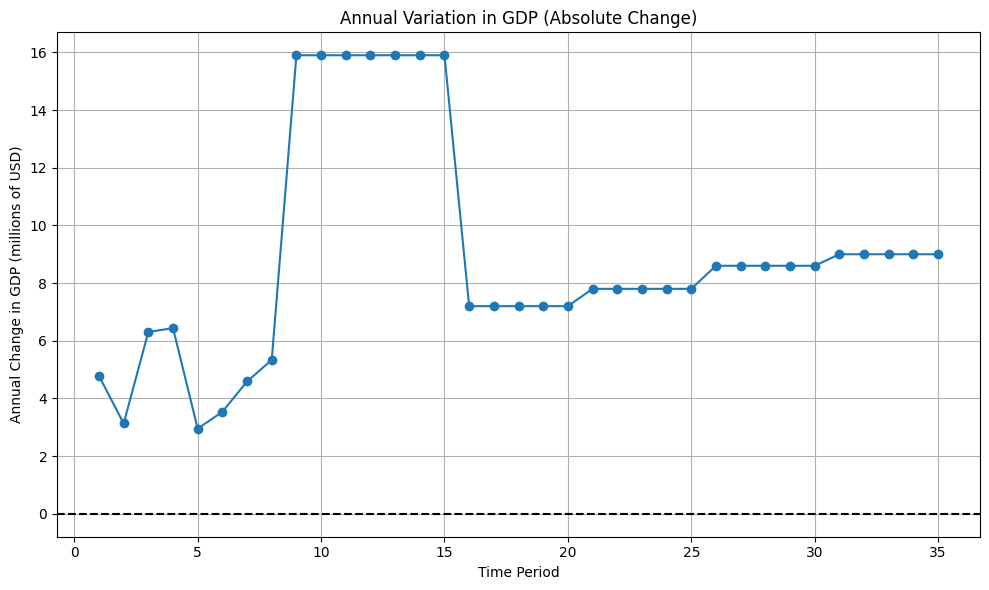

In [37]:
plt.figure(figsize=(10,6))
plt.plot(df_inputs_raw_complete["time_period"], df_inputs_raw_complete["gdp_mmm_usd_pct_change"], marker='o', linestyle='-')

plt.xlabel("Time Period")
plt.ylabel("Annual Change in GDP (millions of USD)")
plt.title("Annual Variation in GDP (Absolute Change)")
plt.axhline(0, color='black', linestyle='--')  # Línea base
plt.grid(True)
plt.tight_layout()
plt.show()

plt.show()

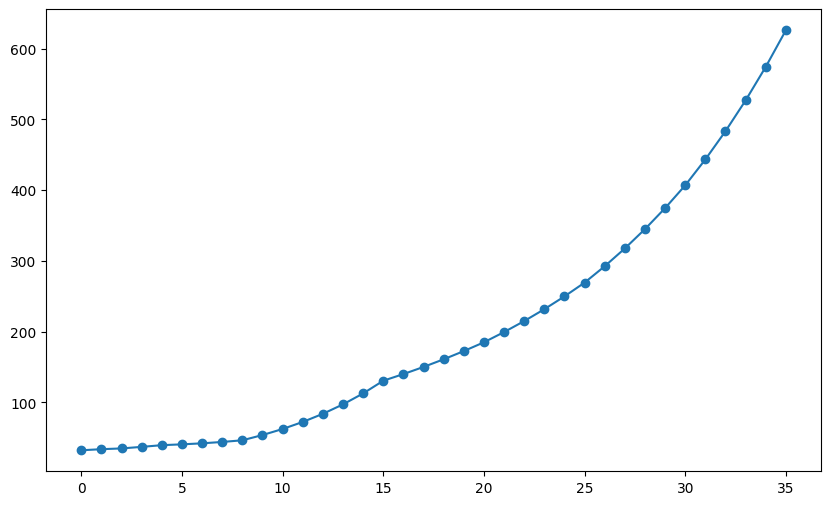

In [38]:
plt.figure(figsize=(10, 6))
plt.plot(df_inputs_raw_complete["time_period"], df_inputs_raw_complete["gdp_mmm_usd"], marker='o')

plt.show()

#  Let's try building transformations using this


In [39]:
transformers = trf.transformers.Transformers(
    {},
    df_input = df_inputs_raw_complete,
)

##  Instantiate some transformations. Make sure to run this cell to create the transformations folder for the first time or if you wish to overwrite

In [40]:
# set an ouput path and instantiate
if not dir_transformations.exists():
    trf.instantiate_default_strategy_directory(
        transformers,
        dir_transformations,
    )
else:
    print(f"Directory {dir_transformations} already exists. Skipping instantiation.")


Directory /home/fabian_fuentes/repos/ssp_uganda/ssp_modeling/transformations already exists. Skipping instantiation.


##  --HERE, CUSTOMIZE YOUR TRANSFORMATIONS AND STRATEGIES--

### Customizing transformations and strategies files using TransformationUtils.py classes

In [41]:
?TransformationYamlProcessor

Init signature:
TransformationYamlProcessor(
    scenario_mapping_excel_path,
    yaml_dir_path,
    sheet_name='yaml',
)
Docstring:     
TransformationYamlProcessor is a class designed to handle the processing of YAML files based on scenario mappings provided in an Excel file. It provides methods to load scenario mappings, retrieve strategy names, load YAML data, save modified YAML files, and process YAML files according to specified transformations.
Methods:
    __init__(self, scenario_mapping_excel_path, yaml_dir_path, sheet_name='yaml'):
        Initializes the TransformationYamlProcessor class with the given parameters.
    load_scenario_mapping_excel(self):
    load_yaml_data(self, yaml_file_path):
    get_strategy_names(self):
    save_yaml_file(self, yaml_content, yaml_name, column, transformation_code, subsector, transformation_name, scalar_val):
    get_transformations_per_strategy_dict(self):
    process_yaml_files(self):
Init docstring:
Initializes the TransformationUtils c

In [42]:
# Generate new transformation files based on the excel mapping file. 
# Make sure to have the most updated format for the excel file, check the one used in this notebook for reference.

cw_file_path = os.path.join(dir_scenario_mapping, ssp_transformation_cw)
print(cw_file_path)
excel_yaml_handler = TransformationYamlProcessor(scenario_mapping_excel_path=cw_file_path, yaml_dir_path=dir_transformations)

/home/fabian_fuentes/repos/ssp_uganda/ssp_modeling/scenario_mapping/ssp_uganda_transformation_cw_2025_04_21.xlsx


In [43]:
# This creates transformation yaml files for each strategy in the excel file
excel_yaml_handler.process_yaml_files()

YAML file transformation_agrc_inc_conservation_agriculture.yaml already exist for strategy strategy_NDC. Please check it manually.
YAML file transformation_agrc_inc_conservation_agriculture.yaml already exist for strategy strategy_NZ. Please check it manually.
YAML file transformation_inen_shift_fuel_heat.yaml already exist for strategy strategy_NZ. Please check it manually.
YAML file transformation_lsmm_inc_management_cattle_pigs.yaml already exist for strategy strategy_NDC. Please check it manually.
YAML file transformation_lsmm_inc_management_cattle_pigs.yaml already exist for strategy strategy_NZ. Please check it manually.
YAML file transformation_lsmm_inc_management_other.yaml already exist for strategy strategy_NDC. Please check it manually.
YAML file transformation_lsmm_inc_management_other.yaml already exist for strategy strategy_NZ. Please check it manually.
YAML file transformation_lsmm_inc_management_poultry.yaml already exist for strategy strategy_NDC. Please check it manua

In [44]:
# Load the transformations per strategy dictionary so we can pass it to the strategy handler
# You can also check here if the transformations in each strategy are correct
transformation_per_strategy_dict = excel_yaml_handler.get_transformations_per_strategy_dict()
transformation_per_strategy_dict

{'strategy_NDC': ['TX:AGRC:DEC_CH4_RICE_STRATEGY_NDC',
  'TX:AGRC:INC_CONSERVATION_AGRICULTURE_STRATEGY_NDC',
  'TX:AGRC:INC_PRODUCTIVITY_STRATEGY_NDC',
  'TX:ENTC:DEC_LOSSES_STRATEGY_NDC',
  'TX:ENTC:TARGET_CLEAN_HYDROGEN_STRATEGY_NDC',
  'TX:ENTC:TARGET_RENEWABLE_ELEC_STRATEGY_NDC',
  'TX:INEN:INC_EFFICIENCY_ENERGY_STRATEGY_NDC',
  'TX:INEN:INC_EFFICIENCY_PRODUCTION_STRATEGY_NDC',
  'TX:IPPU:DEC_CLINKER_STRATEGY_NDC',
  'TX:IPPU:DEC_DEMAND_STRATEGY_NDC',
  'TX:IPPU:DEC_HFCS_STRATEGY_NDC',
  'TX:LNDU:DEC_DEFORESTATION_STRATEGY_NDC',
  'TX:LNDU:INC_REFORESTATION_STRATEGY_NDC',
  'TX:LSMM:INC_CAPTURE_BIOGAS_STRATEGY_NDC',
  'TX:LSMM:INC_MANAGEMENT_CATTLE_PIGS_STRATEGY_NDC',
  'TX:LSMM:INC_MANAGEMENT_OTHER_STRATEGY_NDC',
  'TX:LSMM:INC_MANAGEMENT_POULTRY_STRATEGY_NDC',
  'TX:LVST:INC_PRODUCTIVITY_STRATEGY_NDC',
  'TX:SOIL:DEC_LIME_APPLIED_STRATEGY_NDC',
  'TX:SOIL:DEC_N_APPLIED_STRATEGY_NDC',
  'TX:TRDE:DEC_DEMAND_STRATEGY_NDC',
  'TX:TRNS:INC_EFFICIENCY_ELECTRIC_STRATEGY_NDC',
  'TX:TRN

In [45]:
transformation_per_strategy_dict.keys()

dict_keys(['strategy_NDC', 'strategy_NZ'])

### Creating new strategies
- You can create new strategies from scratch.
- You can also update existing ones.

In [46]:
# Creating new strategies by updating the strategy_definitions file.
# You can edit this to add yours, as many as you want.
csv_handler = StrategyCSVHandler(strategies_definitions_file_path, dir_transformations, strategy_mapping_file_path, transformation_per_strategy_dict)

#csv_handler.add_strategy(strategy_group='PFLO', description='NDC BaU', yaml_file_suffix='BaU')
csv_handler.add_strategy(strategy_group='PFLO', description='NDC', yaml_file_suffix='NDC')
csv_handler.add_strategy(strategy_group='PFLO', description='Net Zero', yaml_file_suffix='NZ')


INFO: Strategy code PFLO:NDC already exists in the strategy definitions. Strategy will be updated...
Updated row with strategy_code PFLO:NDC
INFO: Strategy code PFLO:NZ already exists in the strategy definitions. Strategy will be updated...
Updated row with strategy_code PFLO:NZ


In [47]:
# Set up the strategy codes you wish to run in ssp
strategies_to_run = [0, 6003, 6004]

# Manual modification YAML

## TX:LNDU:DEC_DEFORESTATION

In [48]:

import yaml

with open(os.path.join(dir_transformations, 'transformation_lndu_dec_deforestation_strategy_NZ.yaml'), 'r') as file:
    data = yaml.safe_load(file)


data['parameters']['magnitude'] = 0.999999   


with open(os.path.join(dir_transformations, 'transformation_lndu_dec_deforestation_strategy_NZ.yaml'), 'w') as file:
    yaml.dump(data, file, sort_keys=False)

  

In [49]:

with open(os.path.join(dir_transformations, 'transformation_lndu_dec_deforestation_strategy_NDC.yaml'), 'r') as file:
    data = yaml.safe_load(file)


data['parameters']['magnitude'] = 0.989999


with open(os.path.join(dir_transformations, 'transformation_lndu_dec_deforestation_strategy_NDC.yaml'), 'w') as file:
    yaml.dump(data, file, sort_keys=False) 

## TX:AGRC:INC_CONSERVATION_AGRICULTURE

In [50]:
with open(os.path.join(dir_transformations, 'transformation_agrc_inc_conservation_agriculture_strategy_NZ.yaml'), 'r') as file:
    data = yaml.safe_load(file)


data['parameters']['magnitude_burned'] = 0.8
data['parameters']['magnitude_removed'] = 0.8   


with open(os.path.join(dir_transformations, 'transformation_agrc_inc_conservation_agriculture_strategy_NZ.yaml'), 'w') as file:
    yaml.dump(data, file, sort_keys=False) 

In [51]:
with open(os.path.join(dir_transformations, 'transformation_agrc_inc_conservation_agriculture_strategy_NDC.yaml'), 'r') as file:
    data = yaml.safe_load(file)


data['parameters']['magnitude_burned'] = 0.6
data['parameters']['magnitude_removed'] = 0.6   


with open(os.path.join(dir_transformations, 'transformation_agrc_inc_conservation_agriculture_strategy_NDC.yaml'), 'w') as file:
    yaml.dump(data, file, sort_keys=False) 

### We finished adding new transformation files and strategies so lets load them back

In [52]:
# then, you can load this back in after modifying (play around with it)
transformations = trf.Transformations(
    dir_transformations,
    transformers = transformers,
)
tab = transformations.attribute_transformation.table

In [53]:
#  build the strategies -- will export to path
t0 = time.time()
strategies = trf.Strategies(
    transformations,
    export_path = "transformations",
    prebuild = True,
)

t_elapse = sf.get_time_elapsed(t0)
print(f"Strategies defined at {strategies.transformations.dir_init} initialized in {t_elapse} seconds")

Strategies defined at /home/fabian_fuentes/repos/ssp_uganda/ssp_modeling/transformations initialized in 3.83 seconds


In [54]:
strategies.attribute_table

,strategy_id,strategy_code,strategy,description,transformation_specification,baseline_strategy_id
0,0,BASE,Strategy TX:BASE,NaN,TX:BASE,1
1,1000,AGRC:DEC_CH4_RICE,Singleton - Default Value - AGRC: Improve rice...,NaN,TX:AGRC:DEC_CH4_RICE,0
2,1001,AGRC:DEC_EXPORTS,Singleton - Default Value - AGRC: Decrease Exp...,NaN,TX:AGRC:DEC_EXPORTS,0
3,1002,AGRC:DEC_LOSSES_SUPPLY_CHAIN,Singleton - Default Value - AGRC: Reduce suppl...,NaN,TX:AGRC:DEC_LOSSES_SUPPLY_CHAIN,0
4,1003,AGRC:INC_CONSERVATION_AGRICULTURE,Singleton - Default Value - AGRC: Expand conse...,NaN,TX:AGRC:INC_CONSERVATION_AGRICULTURE,0
...,...,...,...,...,...,...
66,6000,PFLO:INC_HEALTHIER_DIETS,Singleton - Default Value - PFLO: Change diets,NaN,TX:PFLO:INC_HEALTHIER_DIETS,0
67,6001,PFLO:INC_IND_CCS,Singleton - Default Value - PFLO: Industrial c...,NaN,TX:PFLO:INC_IND_CCS,0
68,6002,PFLO:ALL,All Actions,All actions (unique by transformer),TX:AGRC:DEC_CH4_RICE|TX:AGRC:DEC_EXPORTS|TX:AG...,0
69,6003,PFLO:NDC,NDC,NDC,TX:AGRC:DEC_CH4_RICE_STRATEGY_NDC|TX:AGRC:INC_...,0


##  Build our templates
- let's use the default variable groupings for LHS

In [55]:
# Building excel templates, make sure to include the strategies ids in the strategies attribute as well as the baseline (0)
df_vargroups = examples("variable_trajectory_group_specification")

strategies.build_strategies_to_templates(
    df_trajgroup = df_vargroups,
    include_simplex_group_as_trajgroup = True,
    strategies = strategies_to_run,
)

starting strat 6003 with input shape (36, 2260)
strat 6003 with output shape (36, 2260)
here = 6003
starting strat 6004 with input shape (36, 2260)
strat 6004 with output shape (36, 2260)
here = 6004


0

# Finally, load SISEPUEDE so that we can run it

In [56]:
import sisepuede as si
# timestamp_str = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
ssp = si.SISEPUEDE(
    "calibrated",
    db_type = "csv",
    # id_str = f"sisepuede_run_2024-11-04T09:23:26.721580",
    initialize_as_dummy = not(energy_model_flag), # no connection to Julia is initialized if set to True
    regions = [country_name],
    strategies = strategies,
    try_exogenous_xl_types_in_variable_specification = True,
)

2025-04-28 14:07:12,316 - INFO - Successfully initialized SISEPUEDEFileStructure.
2025-04-28 14:07:12,318 - WARNING - Missing key dict_dimensional_keys: key time_series not found. Tables that rely on the time_series will not have index checking.
2025-04-28 14:07:12,319 - INFO - 	Setting export engine to 'csv'.
2025-04-28 14:07:12,321 - WARNING - No index fields defined. Index field values will not be checked when writing to tables.
2025-04-28 14:07:12,322 - INFO - Successfully instantiated table ANALYSIS_METADATA
2025-04-28 14:07:12,322 - WARNING - No index fields found in ATTRIBUTE_DESIGN. Initializing index fields.
2025-04-28 14:07:12,323 - INFO - Successfully instantiated table ATTRIBUTE_DESIGN
2025-04-28 14:07:12,323 - WARNING - No index fields found in ATTRIBUTE_LHC_SAMPLES_EXOGENOUS_UNCERTAINTIES. Initializing index fields.
2025-04-28 14:07:12,324 - INFO - Successfully instantiated table ATTRIBUTE_LHC_SAMPLES_EXOGENOUS_UNCERTAINTIES
2025-04-28 14:07:12,324 - WARNING - No index fi

In [57]:
not(energy_model_flag)

True

In [58]:
# This runs the model, make sure you edit key_stretegy with the strategy ids you want to execute include baseline (0)
dict_scens = {
    ssp.key_design: [0],
    ssp.key_future: [0],
    ssp.key_strategy: strategies_to_run,
}

ssp.project_scenarios(
    dict_scens,
    save_inputs = True,
    include_electricity_in_energy = energy_model_flag
)

2025-04-28 14:07:41,216 - INFO - 
***	STARTING REGION uganda	***

2025-04-28 14:07:45,144 - INFO - Trying run primary_id = 0 in region uganda
2025-04-28 14:07:45,145 - INFO - Running AFOLU model
2025-04-28 14:07:45,347 - INFO - AFOLU model run successfully completed
2025-04-28 14:07:45,349 - INFO - Running CircularEconomy model
2025-04-28 14:07:45,405 - INFO - CircularEconomy model run successfully completed
2025-04-28 14:07:45,406 - INFO - Running IPPU model
2025-04-28 14:07:45,504 - INFO - IPPU model run successfully completed
2025-04-28 14:07:45,505 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-04-28 14:07:45,529 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-04-28 14:07:45,648 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-04-28 14:07:45,649 - INFO - Running Energy (Fugitive Emissions)
2025-04-28 14:07:45,676 - E

{'uganda': [0, 69069, 70070]}

In [59]:
# Read input and output files
df_out = ssp.read_output(None)
df_in = ssp.read_input(None)

## Baseline

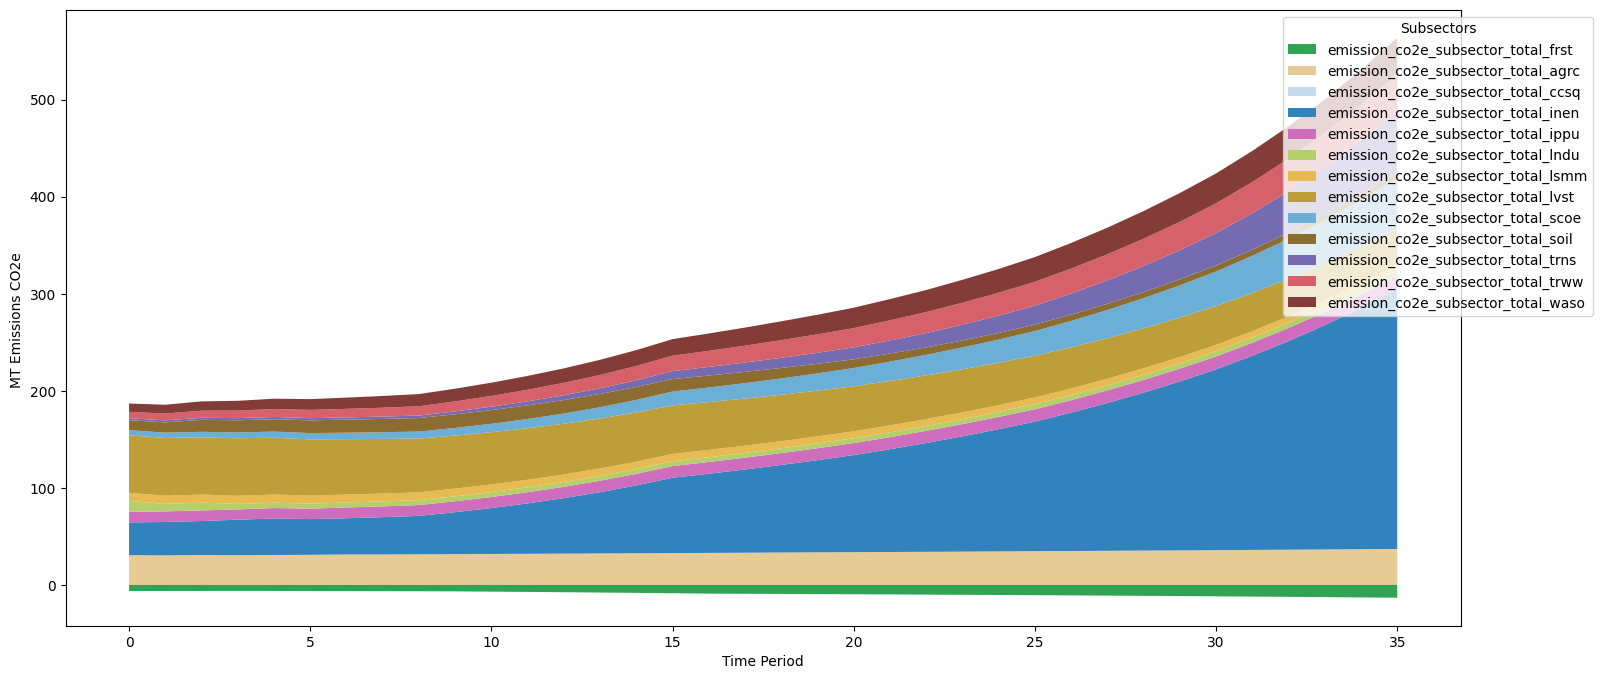

In [60]:

fig, ax = plt.subplots(figsize = (18, 8))
ax.set_xlabel("Time Period")
ax.set_ylabel("MT Emissions CO2e ")

df_plot = df_out[
    df_out[ssp.key_primary].isin([0])
]


fields = matt.get_all_subsector_emission_total_fields()#[x for x in df_out.columns if (x.startswith("emission_co2e_subsector_total"))]
dict_format = dict(
    (k, {"color": v}) for (k, v) in
    matt.get_subsector_color_map().items()
)

fig, ax = spu.plot_stack(
    df_plot,
    fields,
    dict_formatting = dict_format,
    field_x = "time_period",
    figtuple = (fig, ax),
)

ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1), title="Subsectors")

## NDC

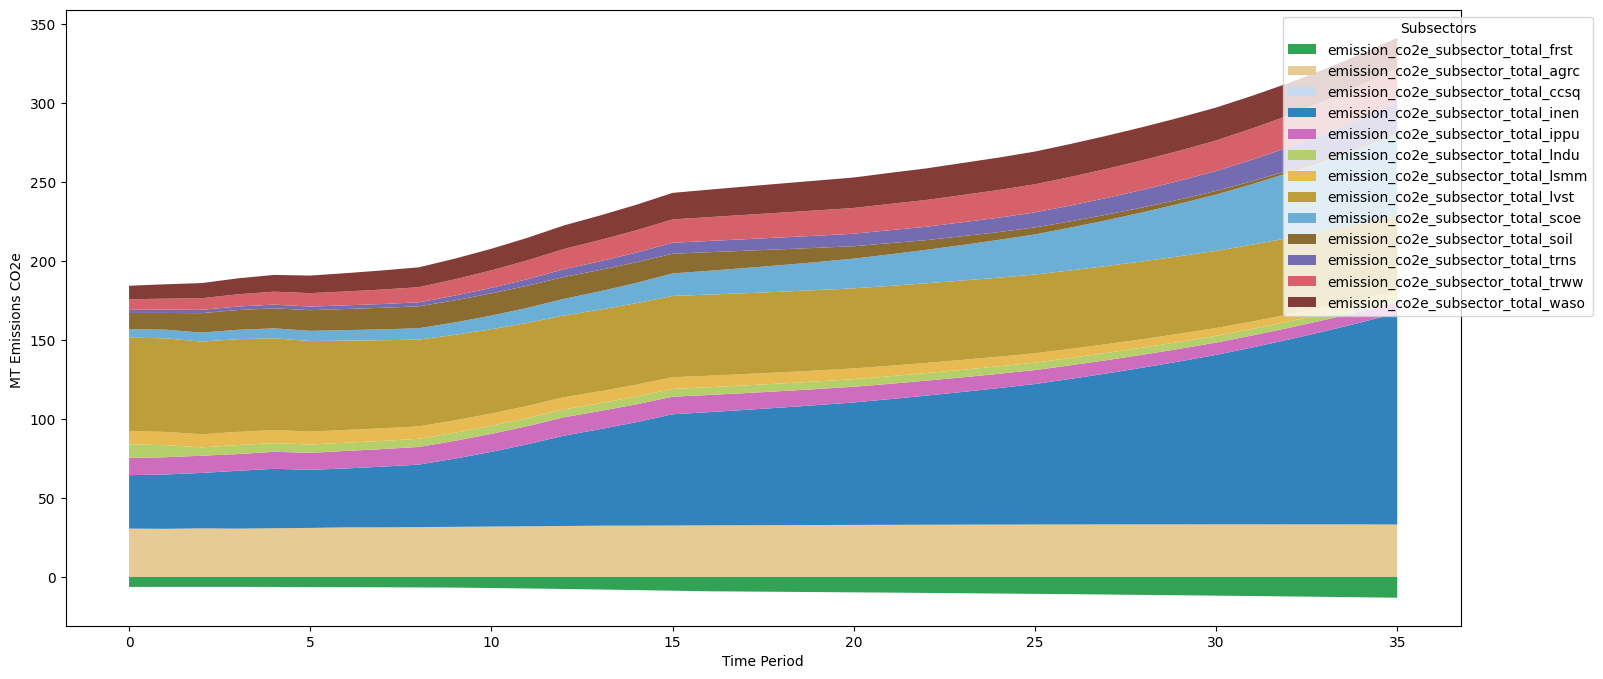

In [61]:
fig, ax = plt.subplots(figsize = (18, 8))
ax.set_xlabel("Time Period")
ax.set_ylabel("MT Emissions CO2e ")

df_plot = df_out[
    df_out[ssp.key_primary].isin([69069])
]


fields = matt.get_all_subsector_emission_total_fields()#[x for x in df_out.columns if (x.startswith("emission_co2e_subsector_total"))]
dict_format = dict(
    (k, {"color": v}) for (k, v) in
    matt.get_subsector_color_map().items()
)

fig, ax = spu.plot_stack(
    df_plot,
    fields,
    dict_formatting = dict_format,
    field_x = "time_period",
    figtuple = (fig, ax),
)

ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1), title="Subsectors")

## Net Zero

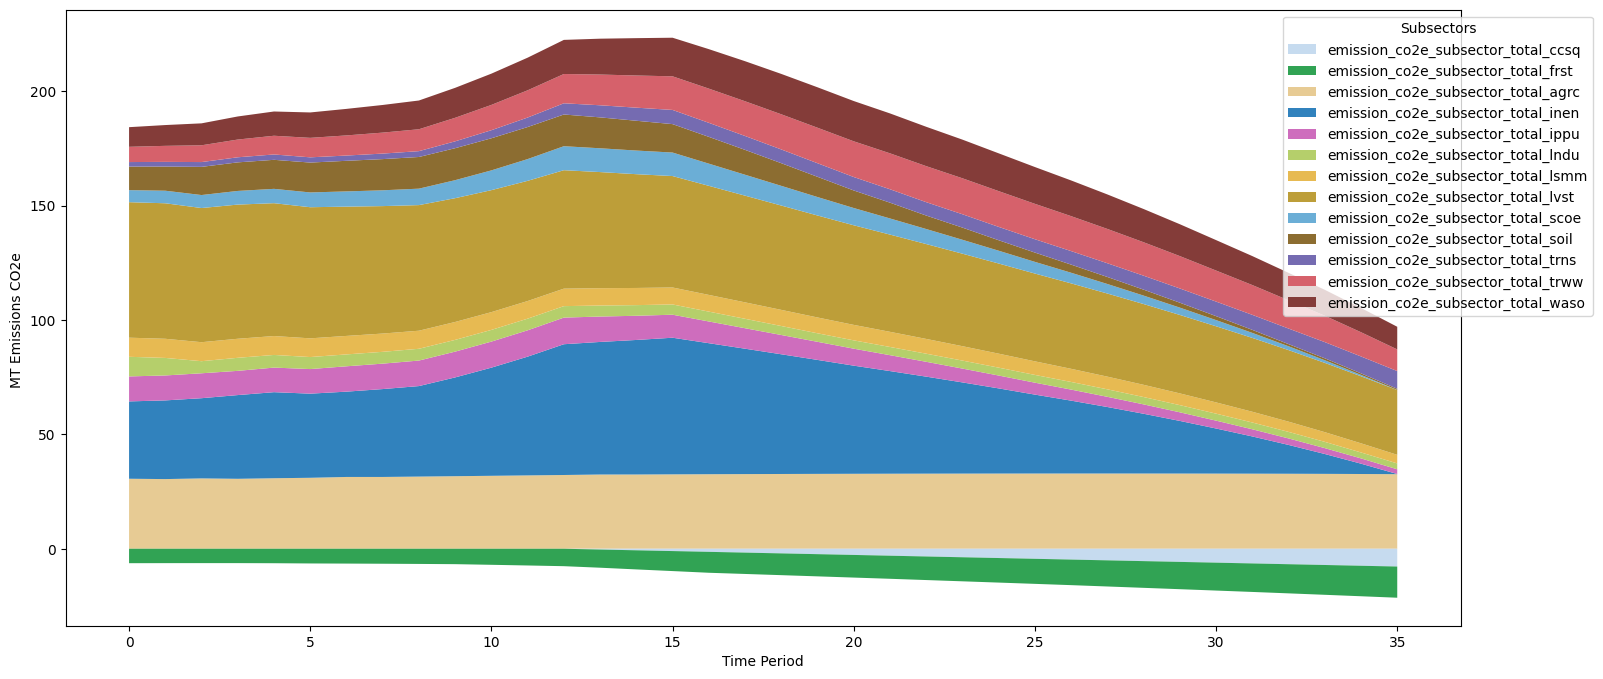

In [62]:
fig, ax = plt.subplots(figsize = (18, 8))
ax.set_xlabel("Time Period")
ax.set_ylabel("MT Emissions CO2e ")

df_plot = df_out[
    df_out[ssp.key_primary].isin([70070])
]


fields = matt.get_all_subsector_emission_total_fields()#[x for x in df_out.columns if (x.startswith("emission_co2e_subsector_total"))]

dict_format = dict(
    (k, {"color": v}) for (k, v) in
    matt.get_subsector_color_map().items()
)

fig, ax = spu.plot_stack(
    df_plot,
    fields,
    dict_formatting = dict_format,
    field_x = "time_period",
    figtuple = (fig, ax),
)
ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1), title="Subsectors")

In [63]:
fields = matt.get_all_subsector_emission_total_fields()
fields

['emission_co2e_subsector_total_agrc',
 'emission_co2e_subsector_total_frst',
 'emission_co2e_subsector_total_lndu',
 'emission_co2e_subsector_total_lsmm',
 'emission_co2e_subsector_total_lvst',
 'emission_co2e_subsector_total_soil',
 'emission_co2e_subsector_total_waso',
 'emission_co2e_subsector_total_trww',
 'emission_co2e_subsector_total_ccsq',
 'emission_co2e_subsector_total_entc',
 'emission_co2e_subsector_total_fgtv',
 'emission_co2e_subsector_total_inen',
 'emission_co2e_subsector_total_scoe',
 'emission_co2e_subsector_total_trns',
 'emission_co2e_subsector_total_ippu']

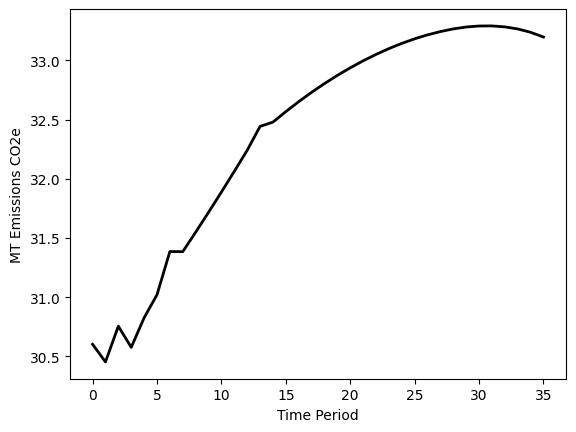

In [64]:
fig, ax = plt.subplots()
ax.set_xlabel("Time Period")
ax.set_ylabel("MT Emissions CO2e")

# Filtrar el dataframe
df_plot = df_out[df_out[ssp.key_primary].isin([69069])]

# Nombre del campo a graficar
soil_field = "emission_co2e_subsector_total_agrc"

# Graficar la línea
ax.plot(
    df_plot["time_period"],
    df_plot[soil_field],
    label="Soil emissions",
    color=matt.get_subsector_color_map().get("soil", "black"),  # Usa el color si está definido, o negro por defecto
    linewidth=2
)

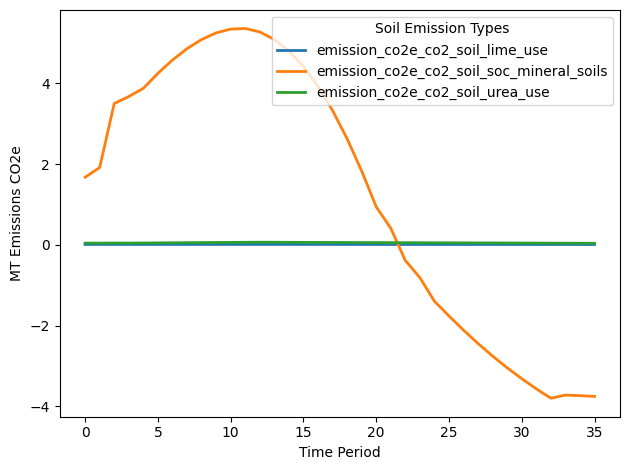

In [65]:
fig, ax = plt.subplots()
ax.set_xlabel("Time Period")
ax.set_ylabel("MT Emissions CO2e")

# Filtrar el dataframe
df_plot = df_out[df_out[ssp.key_primary].isin([70070])]

# Lista de variables a graficar
fields = [
    "emission_co2e_co2_soil_lime_use",
    "emission_co2e_co2_soil_soc_mineral_soils",
    "emission_co2e_co2_soil_urea_use"
]

# Graficar cada campo como una línea
for field in fields:
    ax.plot(
        df_plot["time_period"],
        df_plot[field],
        label=field,
        linewidth=2
    )

# Añadir leyenda
ax.legend(loc='upper right', title="Soil Emission Types")
plt.tight_layout()
plt.show()

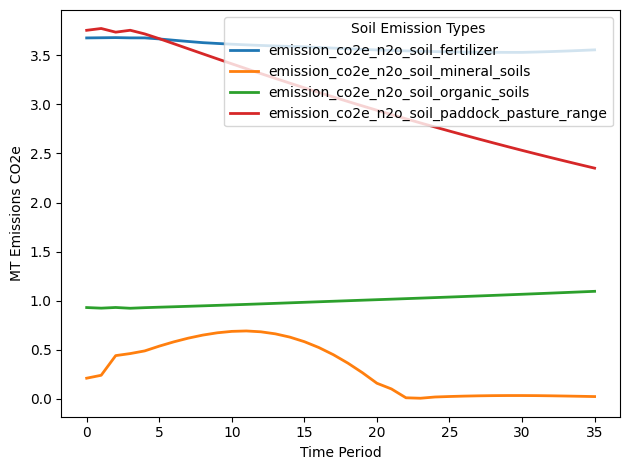

In [66]:
fig, ax = plt.subplots()
ax.set_xlabel("Time Period")
ax.set_ylabel("MT Emissions CO2e")

# Filtrar el dataframe
df_plot = df_out[df_out[ssp.key_primary].isin([0])]

# Lista de variables a graficar
fields = [
    "emission_co2e_n2o_soil_fertilizer",
    "emission_co2e_n2o_soil_mineral_soils",
    "emission_co2e_n2o_soil_organic_soils",
    "emission_co2e_n2o_soil_paddock_pasture_range"
]

# Graficar cada campo como una línea
for field in fields:
    ax.plot(
        df_plot["time_period"],
        df_plot[field],
        label=field,
        linewidth=2
    )

# Añadir leyenda
ax.legend(loc='upper right', title="Soil Emission Types")
plt.tight_layout()
plt.show()

In [67]:
area_lndu = df_out[[i for i in df_out.columns if "area_lndu_" in i]].columns
area_lndu

Index(['area_lndu_conversion_from_croplands',
       'area_lndu_conversion_from_croplands_to_croplands',
       'area_lndu_conversion_from_croplands_to_forests_mangroves',
       'area_lndu_conversion_from_croplands_to_forests_primary',
       'area_lndu_conversion_from_croplands_to_forests_secondary',
       'area_lndu_conversion_from_croplands_to_grasslands',
       'area_lndu_conversion_from_croplands_to_other',
       'area_lndu_conversion_from_croplands_to_settlements',
       'area_lndu_conversion_from_croplands_to_wetlands',
       'area_lndu_conversion_from_forests_mangroves',
       'area_lndu_conversion_from_forests_mangroves_to_croplands',
       'area_lndu_conversion_from_forests_mangroves_to_forests_mangroves',
       'area_lndu_conversion_from_forests_mangroves_to_forests_primary',
       'area_lndu_conversion_from_forests_mangroves_to_forests_secondary',
       'area_lndu_conversion_from_forests_mangroves_to_grasslands',
       'area_lndu_conversion_from_forests_mangrove

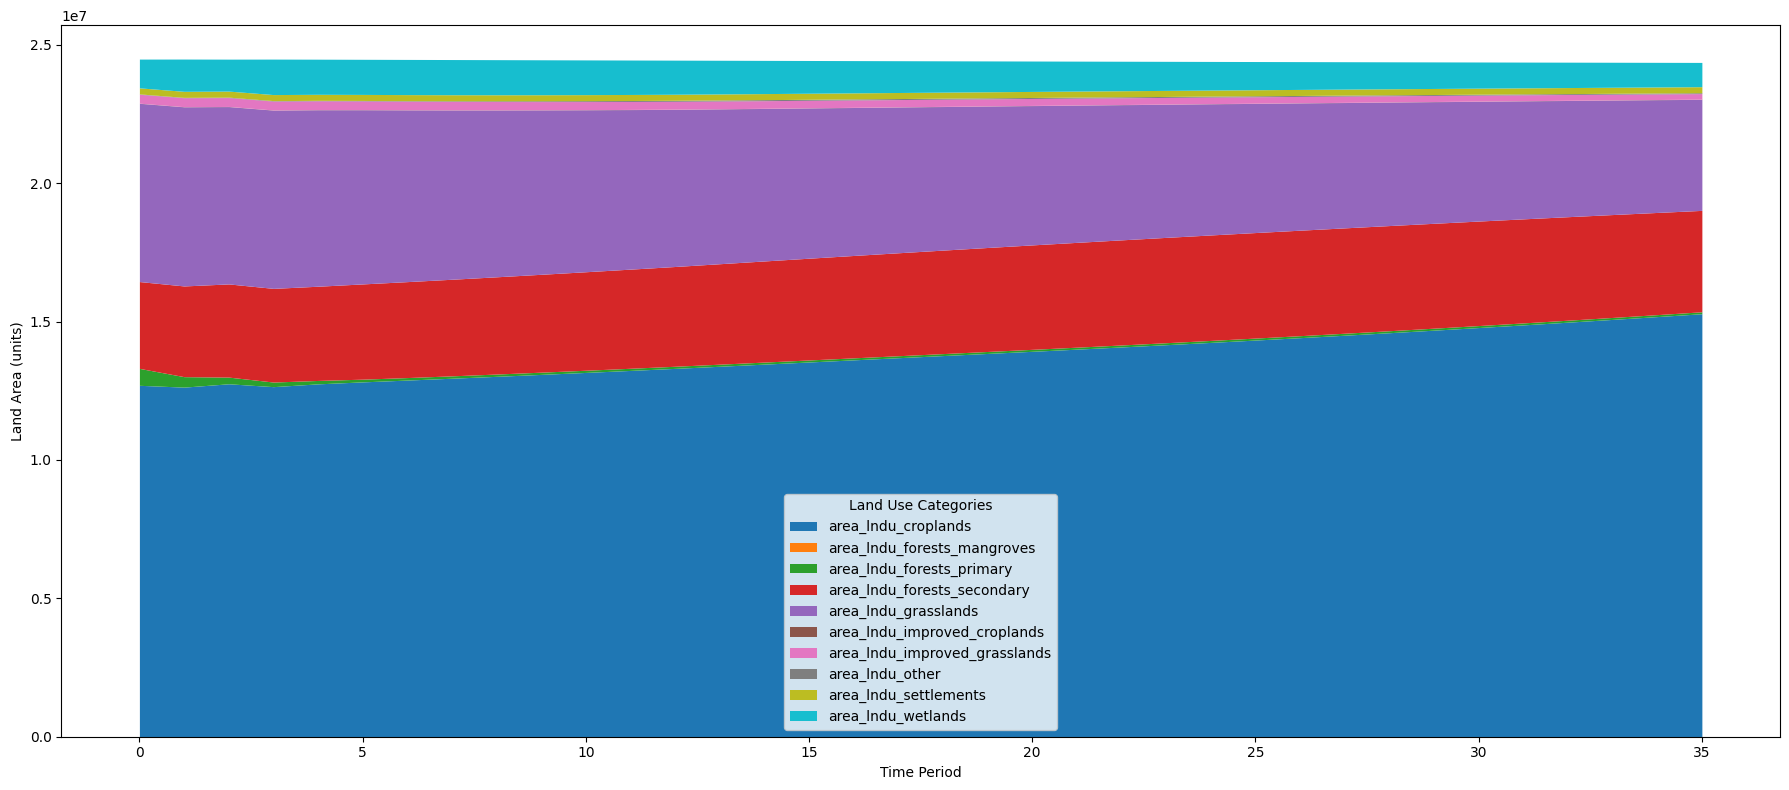

In [68]:
import matplotlib.pyplot as plt

# Filtrar el dataframe
df_plot = df_out[df_out[ssp.key_primary] == 0]

# Lista de variables a graficar
areas = [
    'area_lndu_croplands',
    'area_lndu_forests_mangroves', 'area_lndu_forests_primary',
    'area_lndu_forests_secondary', 'area_lndu_grasslands',
    'area_lndu_improved_croplands', 'area_lndu_improved_grasslands',
    'area_lndu_other', 'area_lndu_settlements', 'area_lndu_wetlands'
]

# Crear el DataFrame para el área
df_area = df_plot.set_index("time_period")[areas]

# Graficar el área apilada
ax = df_area.plot.area(figsize=(18, 8) ,linewidth=0)

# Etiquetas y título
ax.set_xlabel("Time Period")
ax.set_ylabel("Land Area (units)")
ax.legend( title="Land Use Categories")

plt.tight_layout()
plt.show()


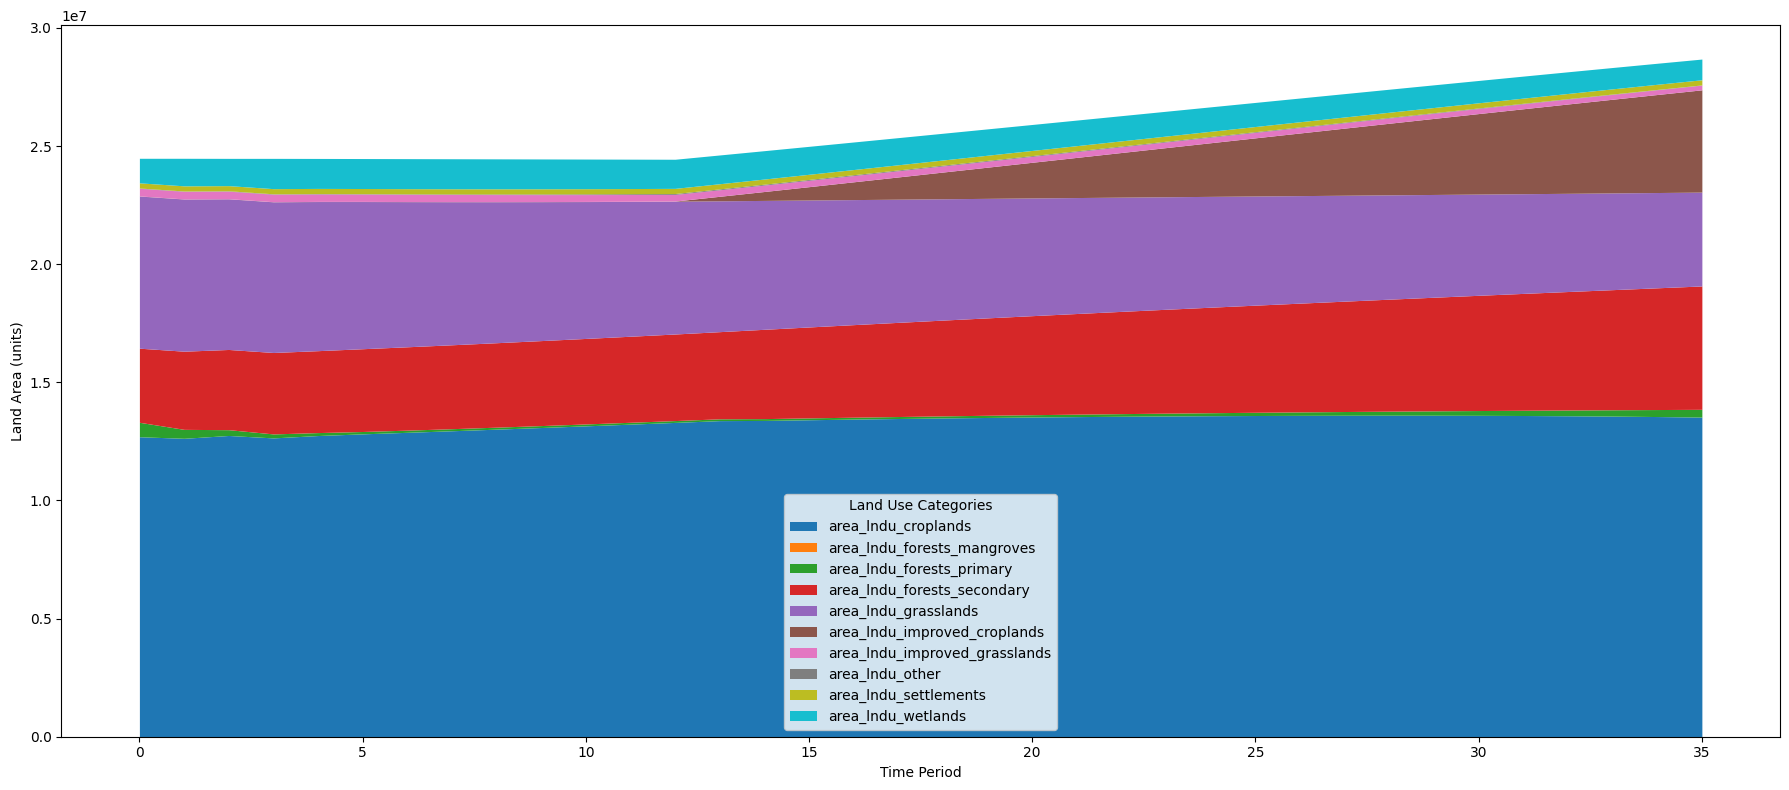

In [69]:
# Filtrar el dataframe
df_plot = df_out[df_out[ssp.key_primary] == 69069]

# Lista de variables a graficar
areas = [
    'area_lndu_croplands',
    'area_lndu_forests_mangroves', 'area_lndu_forests_primary',
    'area_lndu_forests_secondary', 'area_lndu_grasslands',
    'area_lndu_improved_croplands', 'area_lndu_improved_grasslands',
    'area_lndu_other', 'area_lndu_settlements', 'area_lndu_wetlands'
]

# Crear el DataFrame para el área
df_area = df_plot.set_index("time_period")[areas]

# Graficar el área apilada
ax = df_area.plot.area(figsize=(18, 8), linewidth=0)

# Etiquetas y título
ax.set_xlabel("Time Period")
ax.set_ylabel("Land Area (units)")
ax.legend(title="Land Use Categories")

plt.tight_layout()
plt.show()


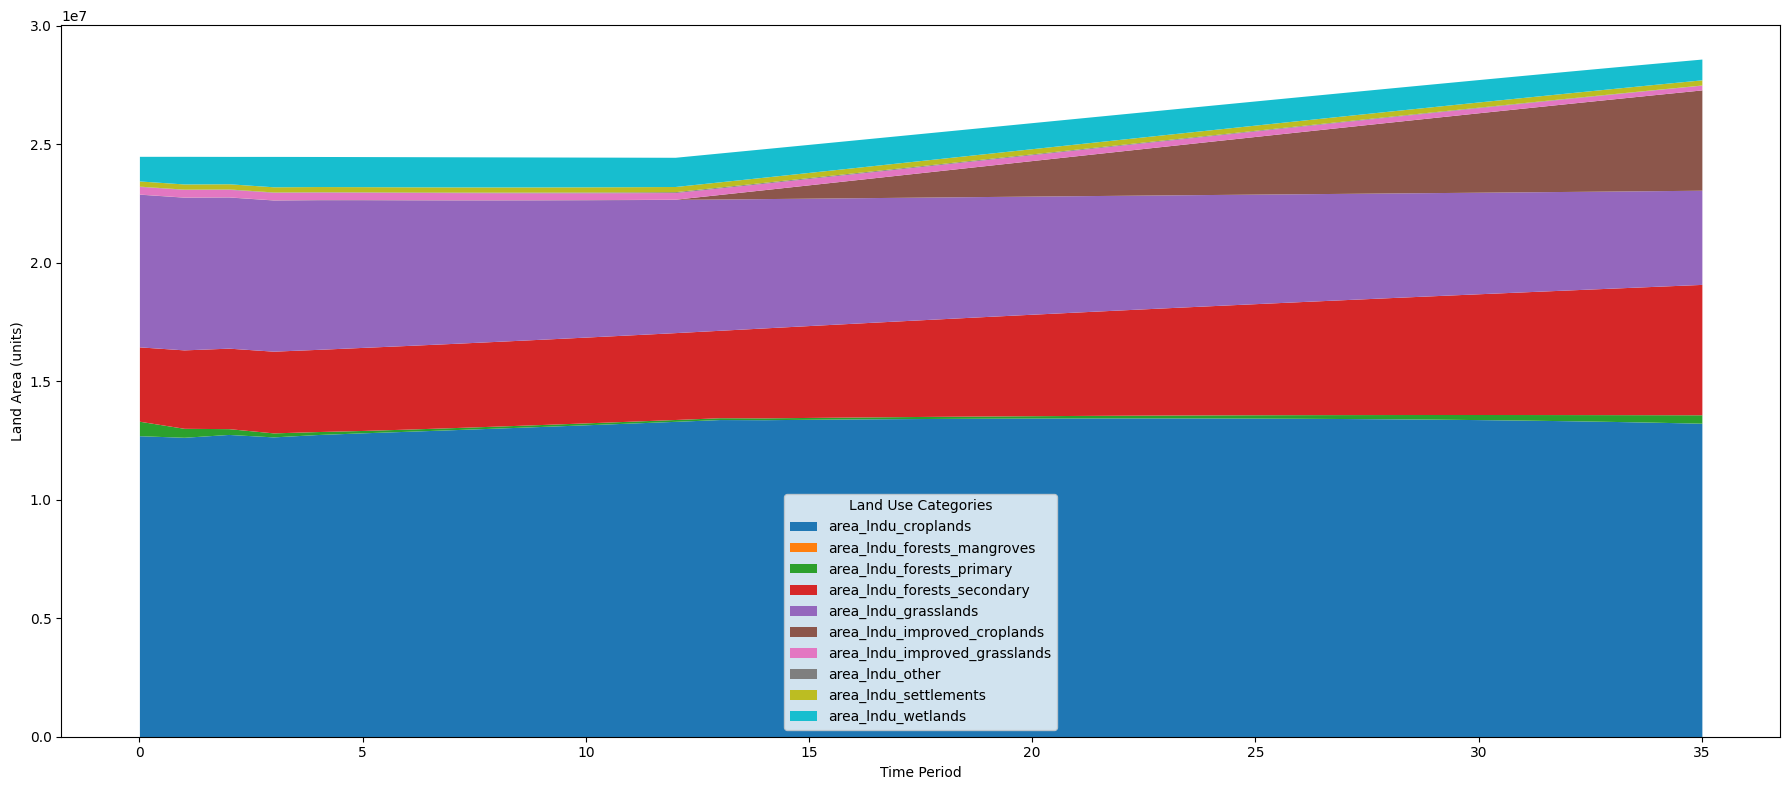

In [70]:
# Filtrar el dataframe
df_plot = df_out[df_out[ssp.key_primary] == 70070]

# Lista de variables a graficar
areas = [
    'area_lndu_croplands',
    'area_lndu_forests_mangroves', 'area_lndu_forests_primary',
    'area_lndu_forests_secondary', 'area_lndu_grasslands',
    'area_lndu_improved_croplands', 'area_lndu_improved_grasslands',
    'area_lndu_other', 'area_lndu_settlements', 'area_lndu_wetlands'
]

# Crear el DataFrame para el área
df_area = df_plot.set_index("time_period")[areas]

# Graficar el área apilada
ax = df_area.plot.area(figsize=(18, 8), linewidth=0)

# Etiquetas y título
ax.set_xlabel("Time Period")
ax.set_ylabel("Land Area (units)")
ax.legend( title="Land Use Categories")

plt.tight_layout()
plt.show()

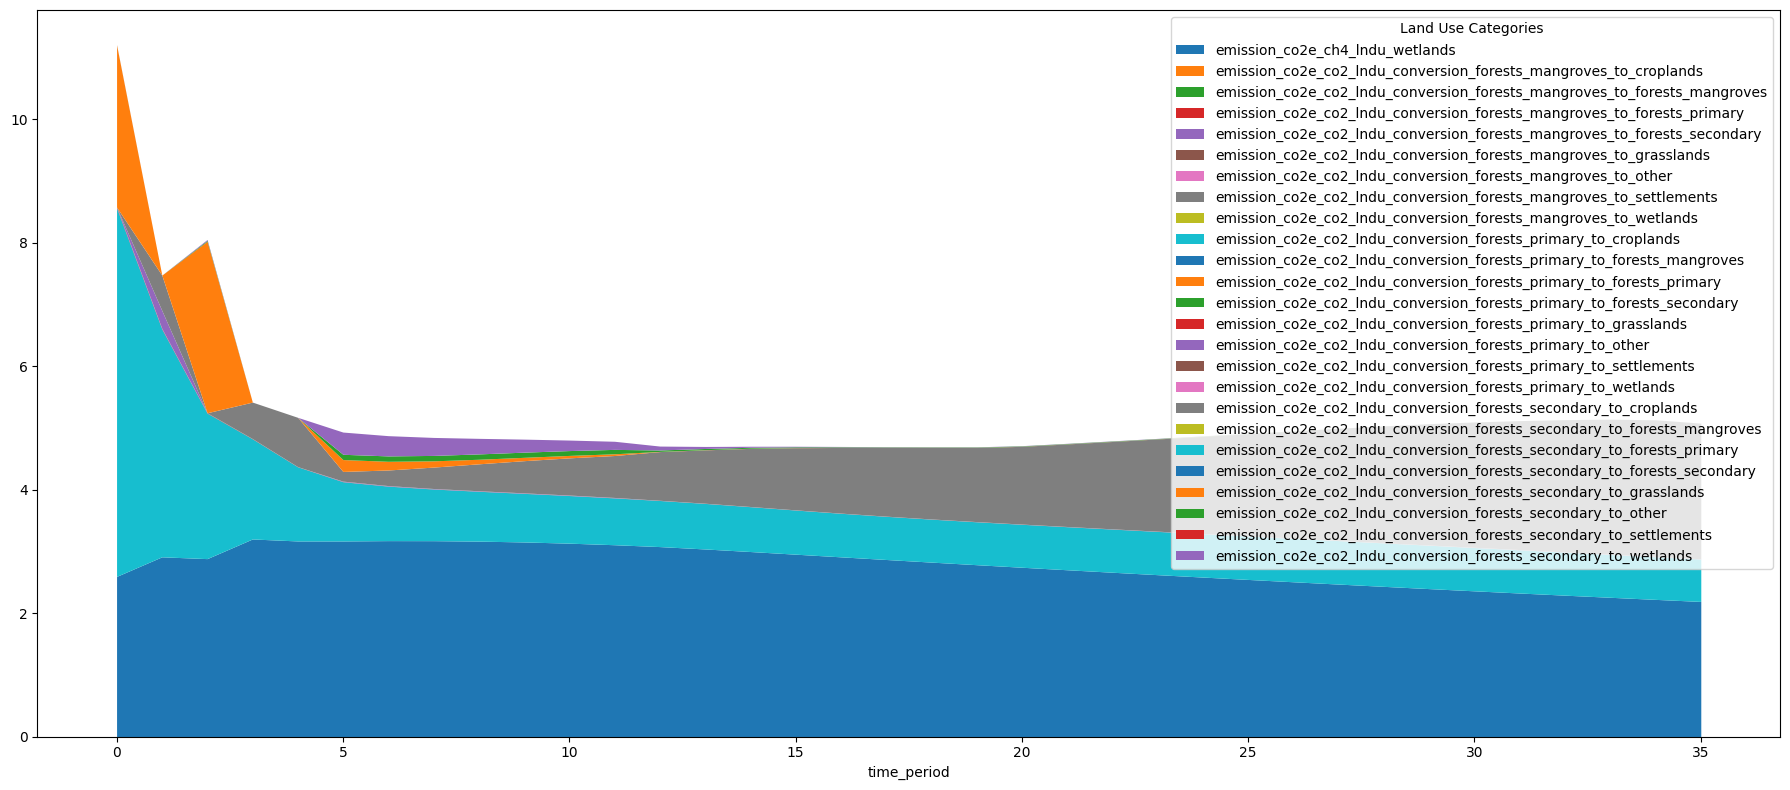

In [71]:
# Filtrar el dataframe
df_plot = df_out[df_out[ssp.key_primary] == 0]

# Lista de variables a graficar
areas= [
    'emission_co2e_ch4_lndu_wetlands',
    "emission_co2e_co2_lndu_conversion_forests_mangroves_to_croplands",
    "emission_co2e_co2_lndu_conversion_forests_mangroves_to_forests_mangroves",
    "emission_co2e_co2_lndu_conversion_forests_mangroves_to_forests_primary",
    "emission_co2e_co2_lndu_conversion_forests_mangroves_to_forests_secondary",
    "emission_co2e_co2_lndu_conversion_forests_mangroves_to_grasslands",
    "emission_co2e_co2_lndu_conversion_forests_mangroves_to_other",
    "emission_co2e_co2_lndu_conversion_forests_mangroves_to_settlements",
    "emission_co2e_co2_lndu_conversion_forests_mangroves_to_wetlands",
    "emission_co2e_co2_lndu_conversion_forests_primary_to_croplands",
    "emission_co2e_co2_lndu_conversion_forests_primary_to_forests_mangroves",
    "emission_co2e_co2_lndu_conversion_forests_primary_to_forests_primary",
    "emission_co2e_co2_lndu_conversion_forests_primary_to_forests_secondary",
    "emission_co2e_co2_lndu_conversion_forests_primary_to_grasslands",
    "emission_co2e_co2_lndu_conversion_forests_primary_to_other",
    "emission_co2e_co2_lndu_conversion_forests_primary_to_settlements",
    "emission_co2e_co2_lndu_conversion_forests_primary_to_wetlands",
    "emission_co2e_co2_lndu_conversion_forests_secondary_to_croplands",
    "emission_co2e_co2_lndu_conversion_forests_secondary_to_forests_mangroves",
    "emission_co2e_co2_lndu_conversion_forests_secondary_to_forests_primary",
    "emission_co2e_co2_lndu_conversion_forests_secondary_to_forests_secondary",
    "emission_co2e_co2_lndu_conversion_forests_secondary_to_grasslands",
    "emission_co2e_co2_lndu_conversion_forests_secondary_to_other",
    "emission_co2e_co2_lndu_conversion_forests_secondary_to_settlements",
    "emission_co2e_co2_lndu_conversion_forests_secondary_to_wetlands"
]


# Crear el DataFrame para el área
df_area = df_plot.set_index("time_period")[areas]

# Graficar el área apilada
ax = df_area.plot.area(figsize=(18, 8), linewidth=0)

# Etiquetas y título

ax.legend( title="Land Use Categories")

plt.tight_layout()
plt.show()

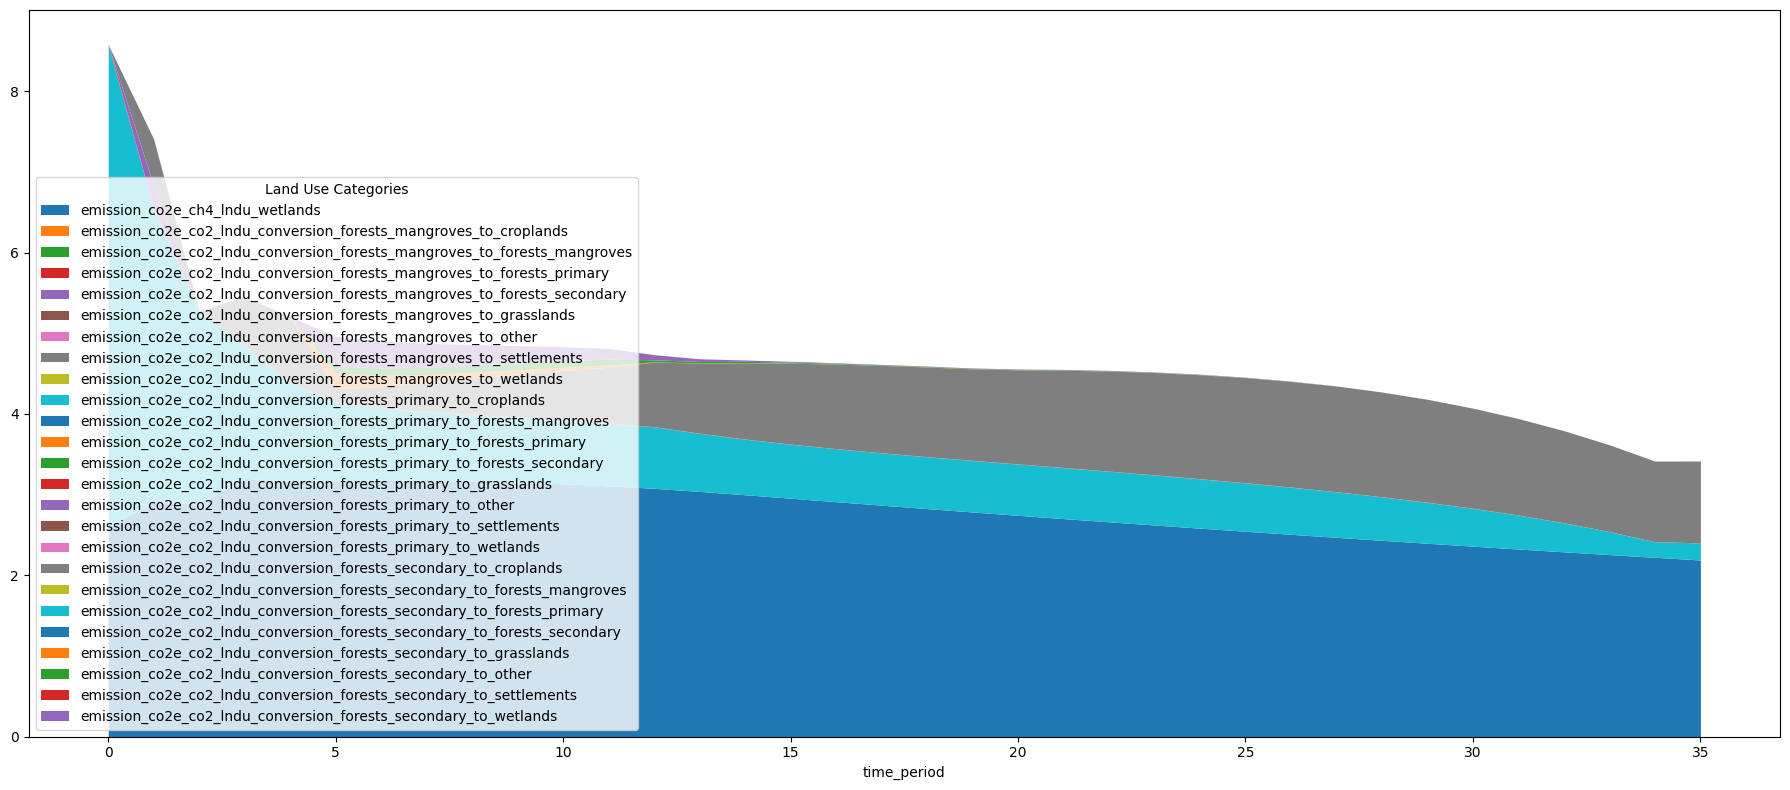

In [72]:
# Filtrar el dataframe
df_plot = df_out[df_out[ssp.key_primary] == 69069]

# Crear el DataFrame para el área
df_area = df_plot.set_index("time_period")[areas]

# Graficar el área apilada
ax = df_area.plot.area(figsize=(18, 8), linewidth=0)

# Etiquetas y título

ax.legend( title="Land Use Categories")

plt.tight_layout()
plt.show()

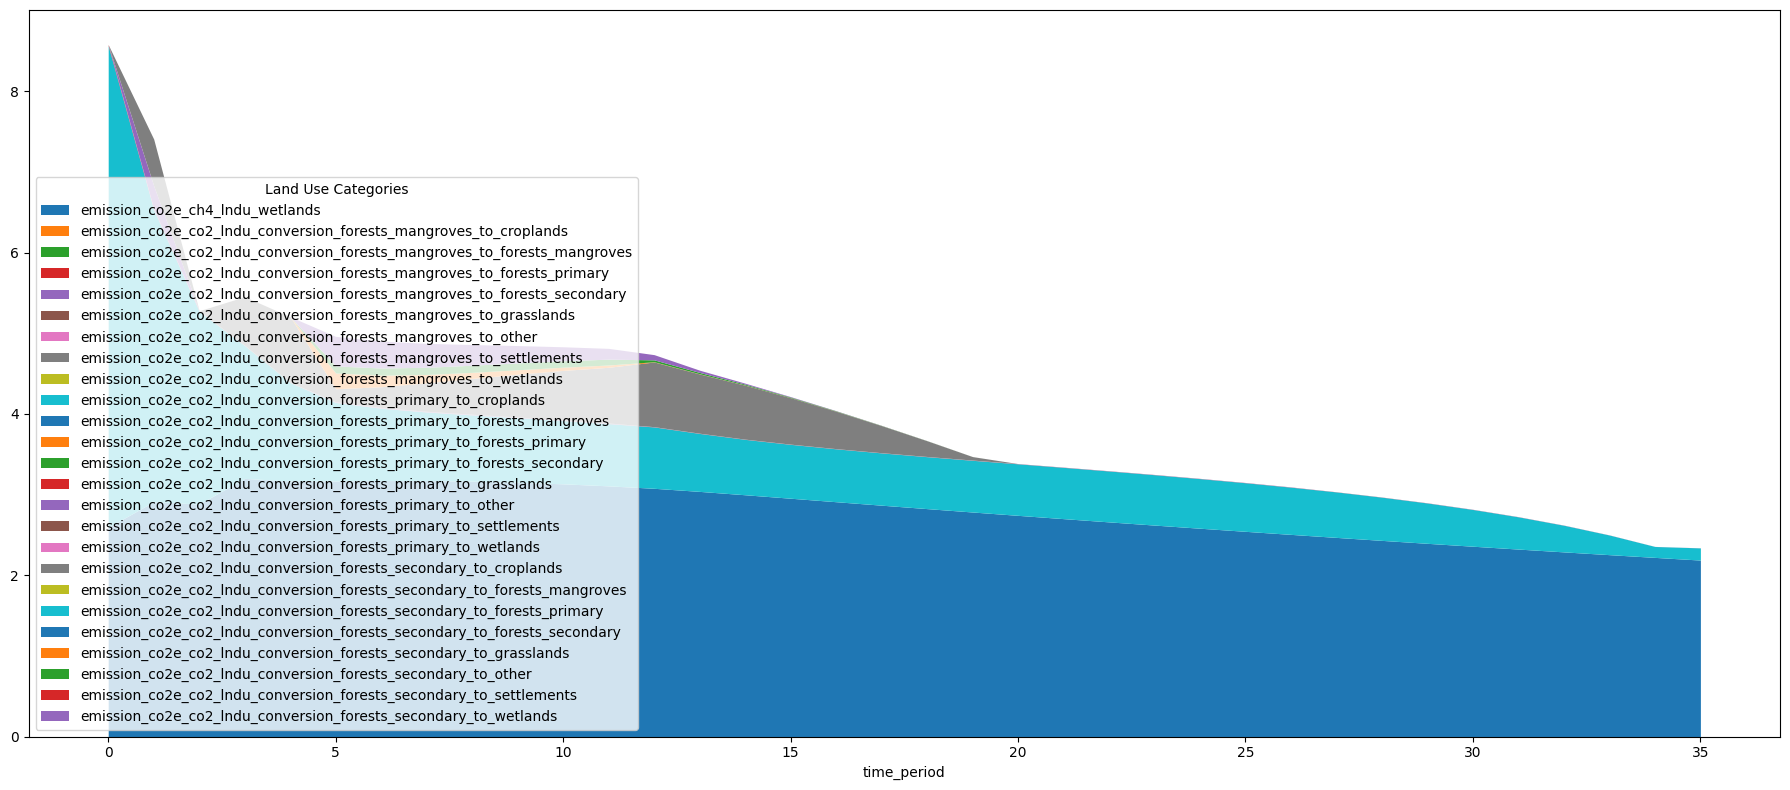

In [73]:
# Filtrar el dataframe
df_plot = df_out[df_out[ssp.key_primary] == 70070]

# Crear el DataFrame para el área
df_area = df_plot.set_index("time_period")[areas]

# Graficar el área apilada
ax = df_area.plot.area(figsize=(18, 8), linewidth=0)

# Etiquetas y título

ax.legend( title="Land Use Categories")

plt.tight_layout()
plt.show()

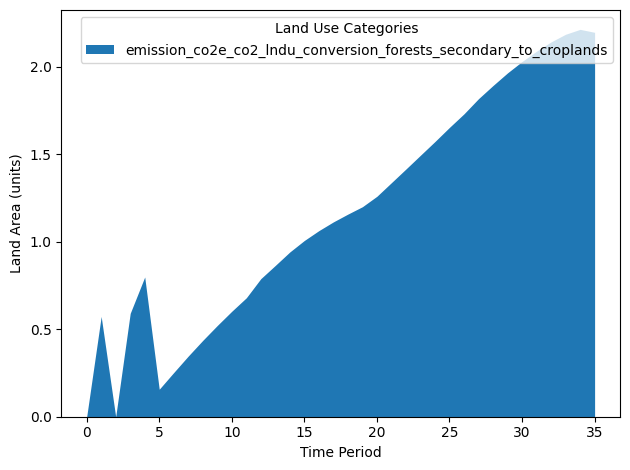

In [74]:
# Filtrar el dataframe
df_plot = df_out[df_out[ssp.key_primary] == 0]

# Lista de variables a graficar
areas= [
    "emission_co2e_co2_lndu_conversion_forests_secondary_to_croplands",
]

# Crear el DataFrame para el área
df_area = df_plot.set_index("time_period")[areas]

# Graficar el área apilada
ax = df_area.plot.area(linewidth=0)

# Etiquetas y título
ax.set_xlabel("Time Period")
ax.set_ylabel("Land Area (units)")
ax.legend(loc='upper right', title="Land Use Categories")

plt.tight_layout()
plt.show()

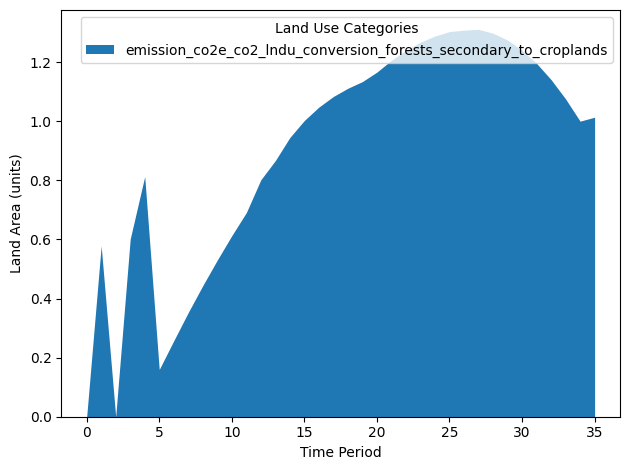

In [75]:
# Filtrar el dataframe
df_plot = df_out[df_out[ssp.key_primary] == 69069]

# Lista de variables a graficar
areas= [
    "emission_co2e_co2_lndu_conversion_forests_secondary_to_croplands",
]

# Crear el DataFrame para el área
df_area = df_plot.set_index("time_period")[areas]

# Graficar el área apilada
ax = df_area.plot.area(linewidth=0)

# Etiquetas y título
ax.set_xlabel("Time Period")
ax.set_ylabel("Land Area (units)")
ax.legend(loc='upper right', title="Land Use Categories")

plt.tight_layout()
plt.show()

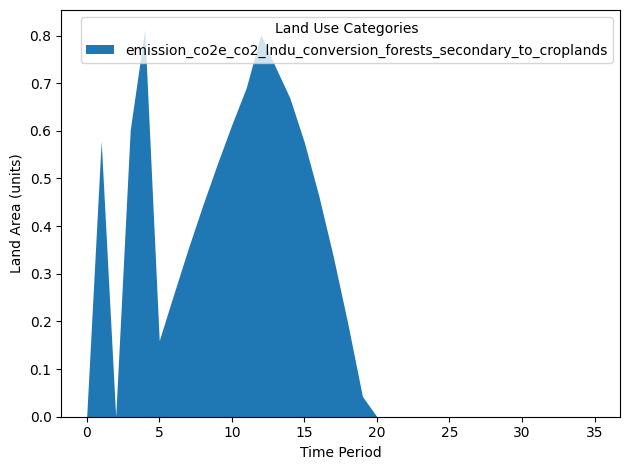

In [76]:
# Filtrar el dataframe
df_plot = df_out[df_out[ssp.key_primary] == 70070 ]

# Lista de variables a graficar
areas= [
    "emission_co2e_co2_lndu_conversion_forests_secondary_to_croplands",
]

# Crear el DataFrame para el área
df_area = df_plot.set_index("time_period")[areas]

# Graficar el área apilada
ax = df_area.plot.area(linewidth=0)

# Etiquetas y título
ax.set_xlabel("Time Period")
ax.set_ylabel("Land Area (units)")
ax.legend(loc='upper right', title="Land Use Categories")

plt.tight_layout()
plt.show()

# Export Wide File (Last Mandatory Step)

In [77]:
df_out = ssp.read_output(None)
df_in = ssp.read_input(None)


all_primaries = sorted(list(df_out[ssp.key_primary].unique()))

# build if unable to simply read the data frame
if df_in is None:
    df_in = []
     
    for region in ssp.regions:
        for primary in all_primaries: 
            df_in_filt = ssp.generate_scenario_database_from_primary_key(primary)
            df_in.append(df_in_filt.get(region))
    
    df_in = pd.concat(df_in, axis = 0).reset_index(drop = True)




df_export = pd.merge(
    df_out,
    df_in,
    how = "left",
)



# check output directory 
dir_pkg = os.path.join(
    ssp.file_struct.dir_out, 
    f"sisepuede_summary_results_run_{ssp.id_fs_safe}"
)
os.makedirs(dir_pkg) if not os.path.exists(dir_pkg) else None


for tab in ["ATTRIBUTE_STRATEGY"]:
    table_df = ssp.database.db.read_table(tab)
    if table_df is not None:
        table_df.to_csv(
            os.path.join(dir_pkg, f"{tab}.csv"),
            index=None,
            encoding="UTF-8"
        )
    else:
        print(f"Warning: Table {tab} returned None.")


df_primary = (
    ssp
    .odpt_primary
    .get_indexing_dataframe(
        sorted(list(df_out[ssp.key_primary].unique()))
    )
)
    
df_primary.to_csv(
    os.path.join(dir_pkg, f"ATTRIBUTE_PRIMARY.csv"),
    index = None,
    encoding = "UTF-8"
)

df_export.to_csv(
    os.path.join(dir_pkg, f"sisepuede_results_{ssp.id_fs_safe}_WIDE_INPUTS_OUTPUTS.csv"),
    index = None,
    encoding = "UTF-8"
)

In [78]:
# Getting the directory where the outputs are stored
ssp.file_struct.dir_out

'/home/fabian_fuentes/anaconda3/envs/ssp_uganda/lib/python3.11/site-packages/sisepuede/out'